In [1]:
from modeling.gen6.api import symbolic, sqrt
from modeling.gen7.api7 import MFunctionalSet, MFunctionalSetLeaf
from engine.torchdata import print_formatted_table, load_vals, ExpandVector
from graph.matrixview import render_incidence
from graph.graphutils import default_tree, all_edges, all_variables
from graph.operators import reformulate
from graph.workflow import order_from_tree
from presolver.tearing import dir_graph, min_arc_set_assign
from scipy import optimize
import numpy as np
import torch

### Goal
Provide full coverage/reproduction of example in Chapter 1 of thesis

### 0) Original formulation

In [2]:
A, Pb, Pc, D, h, R = symbolic('A', 'Pb', 'Pc', 'D', 'h', 'R')
D1 = MFunctionalSetLeaf(Pc == 483.3*A-Pb, idvals=[0]) 
#D1 = MFunctionalSetLeaf(A == (Pb+Pc)/483.3, idvals=[0]) 
D2 = MFunctionalSetLeaf(Pb == 10*sqrt(Pc), idvals=[1]) 
D3 = MFunctionalSetLeaf(R == Pc*D**2/h**2*1e18, idvals=[2]) 
#D3 = MFunctionalSetLeaf(Pc == R*h**2/D**2*1e-18, idvals=[2])
FPF = MFunctionalSet(D1,D2,D3).subsetof(R>=8e6, h>=400e3).minimize(
    2500*D**2+12000*(A+1)+100*Pb)

### 1) Generate restructuring information

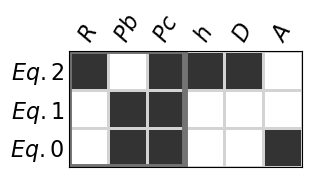

In [3]:
# get structure
sets, _,_,_, indices = FPF.gather_sets()
idxrev = {var.item():key for key,var in indices.items()}
in_outs = {eqid: D.analysis.structure for eqid, D in sets.items()}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
sorted_keys = sorted(Ein.keys())
tree = default_tree(Ein.keys())
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((3,3)),diagonalgray=False);

In [4]:
graph_edges_minassign = all_edges(*edges)
varidxs = all_variables(*edges)
eqnidxs = list(edges[1].keys())
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [5]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_output=['D'])
outset_initial = {comp: var[0] for comp,var in edges[1].items()}
outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-13


In [6]:
str2symb = {str(key):key for key in indices.keys()}
outset_symb = {key:symbolic(str2symb[val])[0] for key,val in outset_opt.items()}
edges_new, tree_new = reformulate(edges, tree, outset_initial, outset_opt, root_solver_name=1)
workflow_order = order_from_tree(tree_new[0], tree_new[1], Eout=edges_new[1])

### 2) Reconfigure original formulation based on presolver or manual specify

In [7]:
FPFr1 = FPF.reconfigure(outset_symb).config_from_order([{2}, {1}, {0}])
FPFr2 = FPF.reconfigure(outset_symb).config_from_workflow(workflow_order)
FPF_MDF = FPF.config(elim=[D3, D2, D1]) # Manual configuration
formulation_of_choice = FPFr2

### 3) Build optimization problem

In [8]:
x0_full = {'A': 1, 'Pb': 10, 'Pc': 10, 'D': 1, 'h': 100e3, 'R': 1}
obj, dobj, xguess, cons, idxs, solidxs = formulation_of_choice.build_opt(x0=x0_full)

In [9]:
xsol = optimize.minimize(obj, xguess, jac=dobj, 
                         constraints=cons, method='SLSQP')

In [10]:
idxrev = {var.item():key for key,var in idxs.items()}
indices_in = {idxrev[val.item()]:torch.tensor([idx]) 
              for idx, val in enumerate(solidxs)}
ev = ExpandVector(indices_in, idxs)
xsolfull = formulation_of_choice.build().analysis(ev(torch.tensor(xsol.x)))

In [11]:
print_formatted_table([np.round(xsolfull,2)], idxs, idxrev)

D    Pc   Pb   A    h      R     
0.67 2.86 16.9 0.04 4.00e5 8.04e6
